# The transient universe

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
from scipy import stats
import emcee
import time
import corner

Let me collect tha data and check the plot

Text(0.5, 1.0, 'Transient')

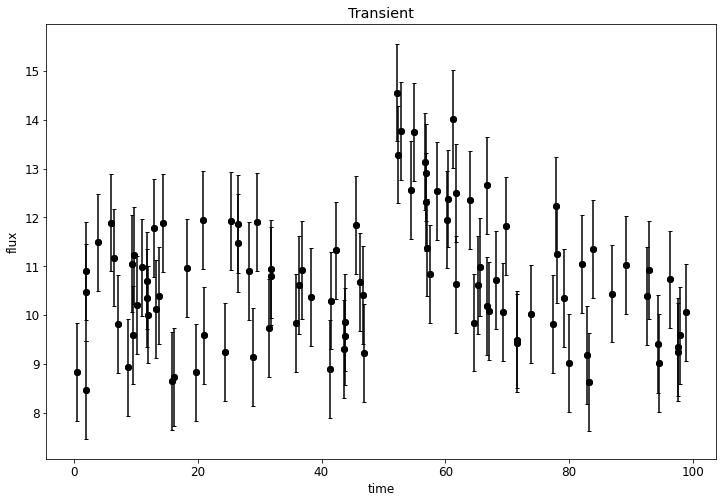

In [2]:
data = np.load("C:/Users/PC/Desktop/UNI/MAGISTRALE/Astrostatistics/transient.npy")

# 1 column = time
# 2 column = flux
# 3 column = homoscedastic uncertianities on flux

plt.figure(figsize=(12,8))
plt.scatter(data[:,0],data[:,1], marker='o',color='black')
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2], fmt='o', color='black', capsize=2)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient')


Definition of the burst model, and visual check in the plot below.
I define by hand the fit parameters.

In [3]:
def burst_model(b,A,t0,alpha,t): 
    return (np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0))))

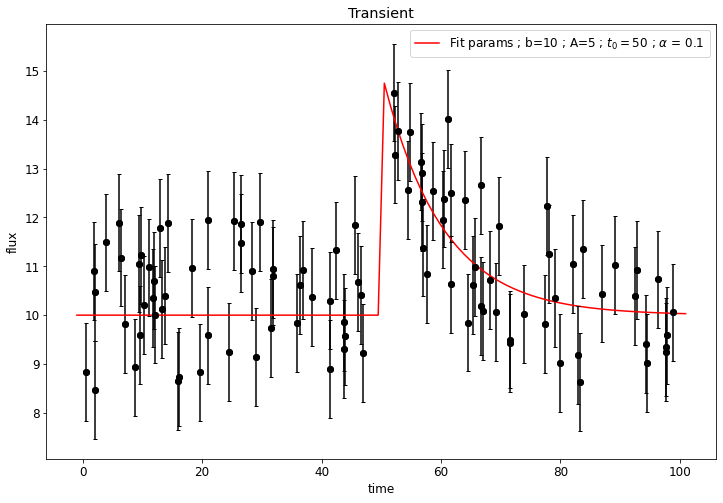

In [4]:
# burst model fit

b_par=10
A_par=5
t0_par=50
alpha_par=0.1

theta_par=[b_par, A_par, t0_par, alpha_par]

xx=np.linspace(-1,101,100)

plt.figure(figsize=(12,8))
plt.plot(xx ,burst_model(b_par,A_par,t0_par,alpha_par,xx), c='red', label=r'Fit params ; b=10 ; A=5 ; $t_0=50$ ; ${\alpha}$ = 0.1 ')
plt.scatter(data[:,0],data[:,1], marker='o',color='black')
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2], fmt='o', color='black', capsize=2)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient')
plt.legend(loc='best')

Consider the model and let me compute the gaussian loglikelihood. 
For the prior I am based on the principle of invariance and I apply a location invariance for the prams. For example:
    $p(b|I) \propto \frac{1}{(b_{max} - b_{min})}$ if $b_{min}<b<b_{max}$ and 0 otherwise

In [5]:
bmin,bmax=0,50
Amin,Amax=0,50
t0min,t0max=0,100
alpha_min, alpha_max= -5,5

def LogLikelihood(theta,model=burst_model):
    A,b,t0,alpha = theta
    x,y, sigma_y = data.T
    y_fit = model(b,A,t0,alpha,x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 )     

def LogPrior(theta):
    A,b,t0,alpha = theta
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alpha_min < np.log(alpha) < alpha_max:
        return 0
    return -np.inf

def LogPosterior(theta):
    return LogLikelihood(theta)+LogPrior(theta)



I adjust these params looking at the chain I plot in a next cell

In [6]:
ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
burn = 100  # "burn-in" period to let chains stabilize
nsteps = int(1e4)  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = theta_par + 1e-1*np.random.random((nwalkers, ndim)) # To initialize theta I use the by hand parameter fitted before



In [7]:

t_start=time.time()
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps,progress=True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

t_stop=time.time()
print("done in time=%1.3f \n" % (t_stop-t_start))
print('sampler chain shape \n',sampler.chain.shape) #original chain structure
print('emcee trace shape',emcee_trace.shape) #burned and flattened chain


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]<ipython-input-5-4a36af0b1709>:14: RuntimeWarning: invalid value encountered in log
  if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alpha_min < np.log(alpha) < alpha_max:
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 470.59it/s]

done in time=21.299 

sampler chain shape 
 (20, 10000, 4)
emcee trace shape (198000, 4)


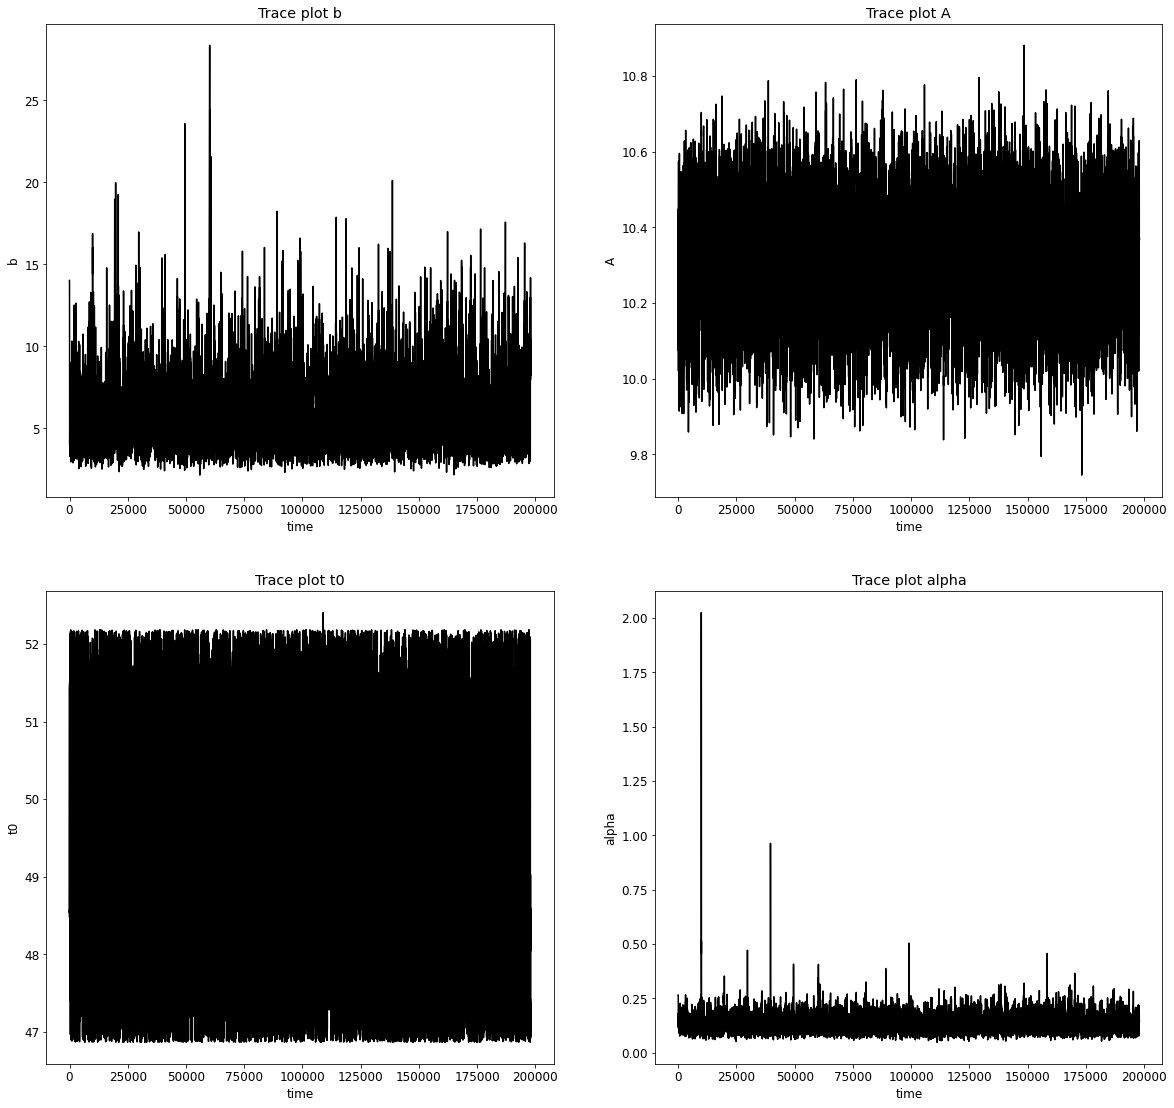

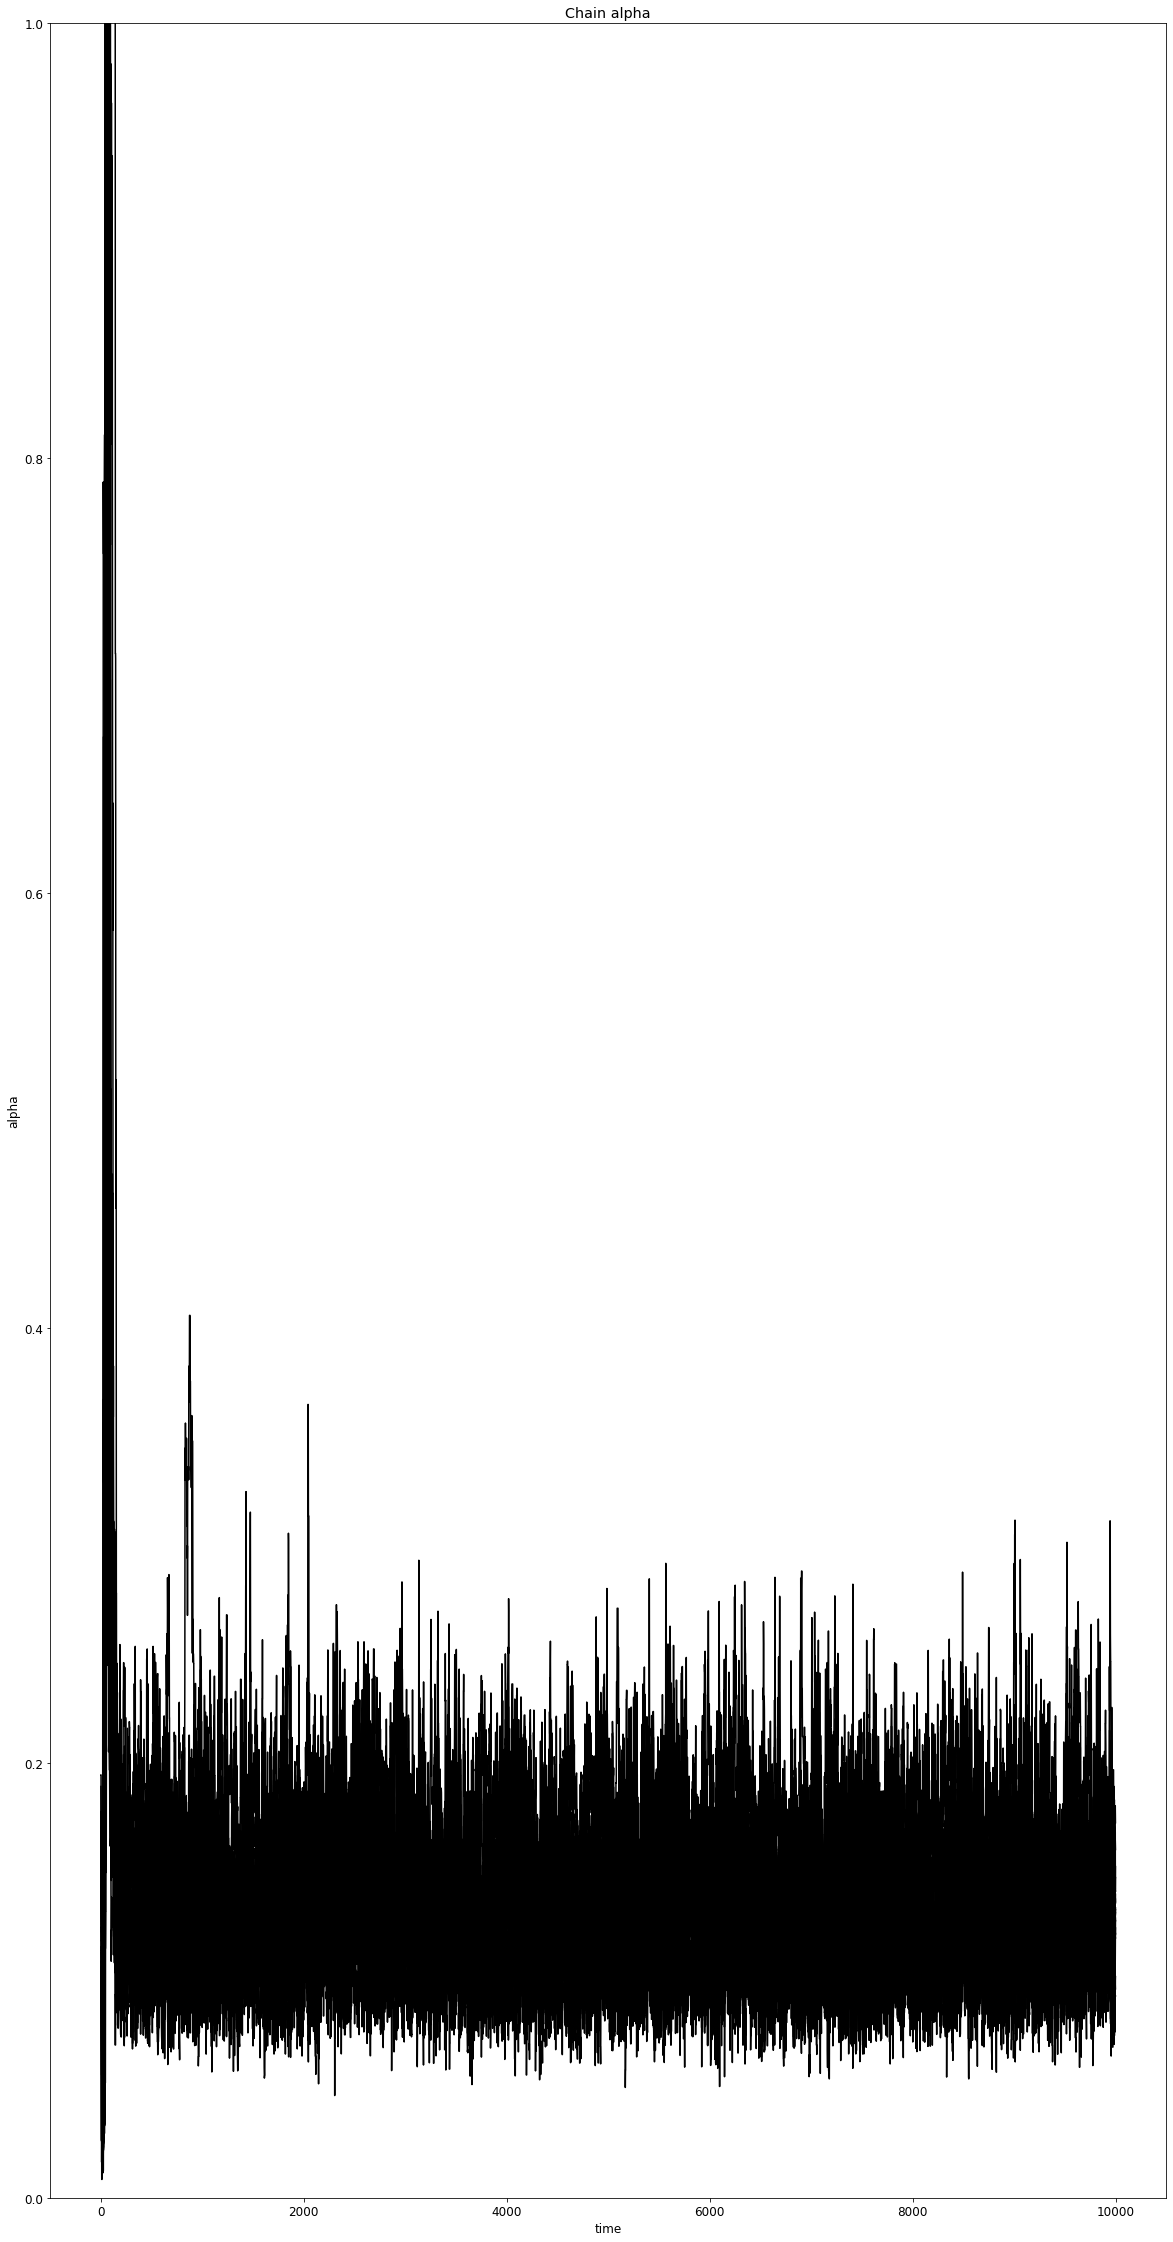

In [13]:
# plot 
labels=['b','A','t0','alpha']
t_grid=np.linspace(0,len(emcee_trace),len(emcee_trace))
samples = sampler.get_chain()

plt.figure(figsize=(20,40))
for i in range(ndim):
    plt.subplot(4,2,i+1)
    plt.title('Trace plot %s' %(labels[i]))
    plt.plot(t_grid,emcee_trace[:,i], c='black')
    plt.ylabel(labels[i])
    plt.xlabel('time')

plt.figure(figsize=(20,40))
for i in range(ndim):
    plt.title('Chain %s'% (labels[i]))
    plt.plot(samples[:,:,i], c='black')
    plt.ylabel(labels[i])
    plt.xlabel('time')
    plt.ylim(0,1)


    



The walkers start to explore the params space around the maximum likelihood and than move to explore all the posterior distribution. As we can understand from the autocorrelation length after 100 steps the sample seem burn-it and so the chain has forgot the initial position.

In [10]:
# thinning

tau = sampler.get_autocorr_time()
print('If small increase the MCMC time of performing', tau)

# Since I have data=arviz.InferenceData object I use the ensambleSampler sampler.get_chain
tau = [69.35368153, 62.64704868, 71.69810494, 58.34767926]
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

If small increase the MCMC time of performing [92.78715096 40.03444729 89.16069664 62.8475278 ]
(2740, 4)


To show the results I use the corner plot that plot both the 1D and 2D projection of the posterior pdf. In particular we can notice the correlation between tha params and the margina pdfs.

<ipython-input-14-8698a094afd7>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


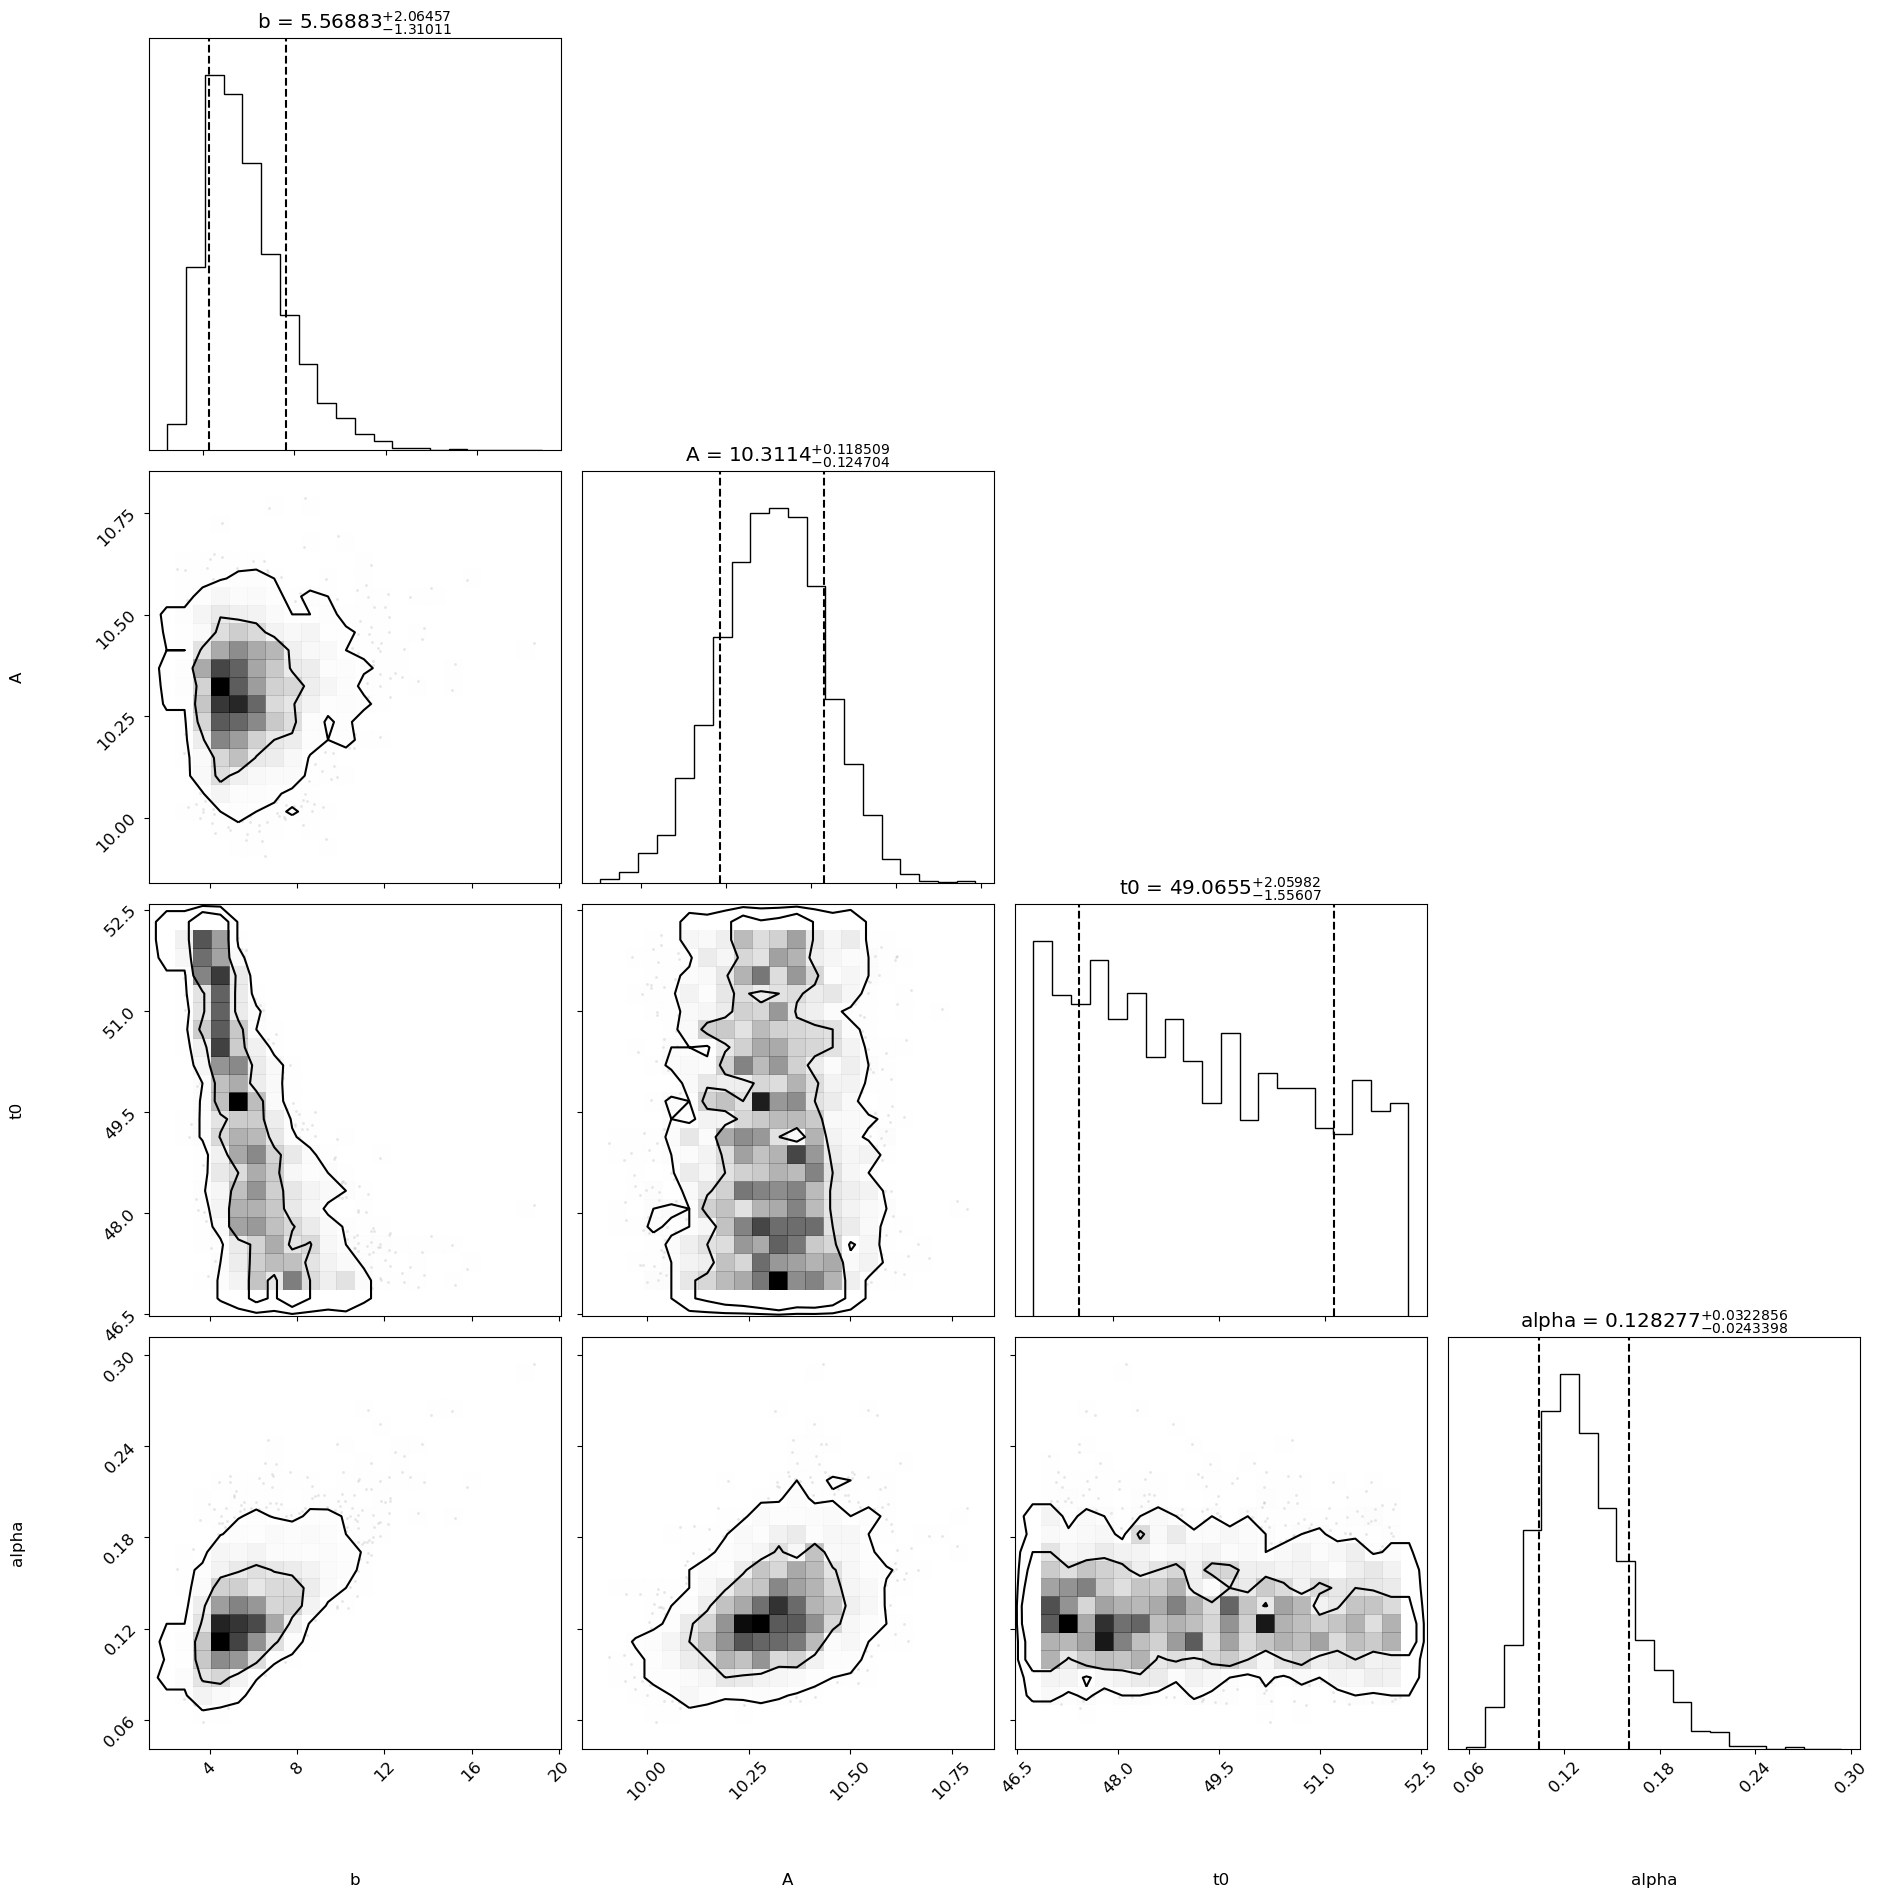

In [14]:
# corner plot


fig=plt.figure(figsize=(20,20),dpi=100)
fig=corner.corner(flat_samples, labels=labels,levels=[0.68,0.95] ,quantiles=(0.16, 0.84),show_titles=True,title_fmt='g', use_math_text=True, fig=fig)
fig.show()